## Purpose
This notebook will take IBD-related SNPs obtained from the EBI GWAS catalog (https://www.ebi.ac.uk/gwas/docs/file-downloads; accessed 7/8/2019).

#### Process:
1. Import the EBI data and filter to obtain IBD SNPs
2. Combine the list of SNP ids and filter to obtain unique SNPs.
3. Use the SNP id's to obtain all SNPs in linkage disequilibrium (LD) with GWAS SNPs

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import requests
from requests_futures.sessions import FuturesSession
from concurrent.futures import as_completed
import time
import json
import re

In [2]:
%cd ../data/snp_data

/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data


### Get the EBI GWAS SNPs

In [3]:
ebi = pd.read_table("source_snps/EBI_GWAS_v1.tab", low_memory=False)

In [4]:
ebi.columns

Index(['DATE ADDED TO CATALOG', 'PUBMEDID', 'FIRST AUTHOR', 'DATE', 'JOURNAL',
       'LINK', 'STUDY', 'DISEASE/TRAIT', 'INITIAL SAMPLE SIZE',
       'REPLICATION SAMPLE SIZE', 'REGION', 'CHR_ID', 'CHR_POS',
       'REPORTED GENE(S)', 'MAPPED_GENE', 'UPSTREAM_GENE_ID',
       'DOWNSTREAM_GENE_ID', 'SNP_GENE_IDS', 'UPSTREAM_GENE_DISTANCE',
       'DOWNSTREAM_GENE_DISTANCE', 'STRONGEST SNP-RISK ALLELE', 'SNPS',
       'MERGED', 'SNP_ID_CURRENT', 'CONTEXT', 'INTERGENIC',
       'RISK ALLELE FREQUENCY', 'P-VALUE', 'PVALUE_MLOG', 'P-VALUE (TEXT)',
       'OR or BETA', '95% CI (TEXT)', 'PLATFORM [SNPS PASSING QC]', 'CNV'],
      dtype='object')

In [5]:
disease_all = ebi['DISEASE/TRAIT'].unique().tolist()

In [7]:
ibd_terms = [x for x in disease_all if any(x.startswith(a) for a in ("Crohn's", "Inflammatory bowel disease", "Ulcerative colitis")) and "pleiotropy" not in x and '(' not in x]
ibd_terms

['Ulcerative colitis',
 "Crohn's disease",
 'Inflammatory bowel disease',
 "Ulcerative colitis or Crohn's disease",
 "Crohn's disease and celiac disease",
 "Crohn's disease and psoriasis",
 "Crohn's disease-related phenotypes"]

In [10]:
ebi_ibd = ebi[[x in ibd_terms for x in ebi['DISEASE/TRAIT']]]
ebi_ibd

,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,...,CONTEXT,INTERGENIC,RISK ALLELE FREQUENCY,P-VALUE,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV
63,2010-03-24,20228798,Franke A,2010-03-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/20228798,Genome-wide association study for ulcerative c...,Ulcerative colitis,"1,043 European ancestry cases, 1,703 European ...","2,539 European ancestry cases, 5,428 European ...",...,intron_variant,0.0,0.52,9.000000e-22,21.045757,NaN,1.41,[1.30-1.54],Affymetrix [1897764] (imputed),N
64,2010-03-24,20228798,Franke A,2010-03-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/20228798,Genome-wide association study for ulcerative c...,Ulcerative colitis,"1,043 European ancestry cases, 1,703 European ...","2,539 European ancestry cases, 5,428 European ...",...,regulatory_region_variant,1.0,0.04,9.000000e-11,10.045757,NaN,1.56,[1.36-1.78],Affymetrix [1897764] (imputed),N
65,2010-03-24,20228798,Franke A,2010-03-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/20228798,Genome-wide association study for ulcerative c...,Ulcerative colitis,"1,043 European ancestry cases, 1,703 European ...","2,539 European ancestry cases, 5,428 European ...",...,missense_variant,0.0,0.49,4.000000e-08,7.397940,NaN,1.17,[1.11-1.25],Affymetrix [1897764] (imputed),N
66,2010-03-24,20228798,Franke A,2010-03-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/20228798,Genome-wide association study for ulcerative c...,Ulcerative colitis,"1,043 European ancestry cases, 1,703 European ...","2,539 European ancestry cases, 5,428 European ...",...,intron_variant,0.0,0.67,4.000000e-15,14.397940,NaN,1.45,[1.33-1.59],Affymetrix [1897764] (imputed),N
67,2010-03-24,20228798,Franke A,2010-03-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/20228798,Genome-wide association study for ulcerative c...,Ulcerative colitis,"1,043 European ancestry cases, 1,703 European ...","2,539 European ancestry cases, 5,428 European ...",...,intron_variant,0.0,0.46,2.000000e-06,5.698970,NaN,1.22,[1.12-1.32],Affymetrix [1897764] (imputed),N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115519,2019-08-22,26398853,Ye BD,2016-01-01,Inflamm Bowel Dis,www.ncbi.nlm.nih.gov/pubmed/26398853,Identification of Ten Additional Susceptibilit...,Ulcerative colitis,"705 Korean ancestry cases, 1,178 Korean ancest...","980 Korean ancestry cases, 2,694 Korean ancest...",...,missense_variant,0.0,0.93,1.000000e-08,8.000000,NaN,1.75,NaN,Illumina [536821] (imputed),N
115520,2019-08-22,26398853,Ye BD,2016-01-01,Inflamm Bowel Dis,www.ncbi.nlm.nih.gov/pubmed/26398853,Identification of Ten Additional Susceptibilit...,Ulcerative colitis,"705 Korean ancestry cases, 1,178 Korean ancest...","980 Korean ancestry cases, 2,694 Korean ancest...",...,intron_variant,0.0,0.69,4.000000e-06,5.397940,NaN,1.24,NaN,Illumina [536821] (imputed),N
115521,2019-08-22,26398853,Ye BD,2016-01-01,Inflamm Bowel Dis,www.ncbi.nlm.nih.gov/pubmed/26398853,Identification of Ten Additional Susceptibilit...,Ulcerative colitis,"705 Korean ancestry cases, 1,178 Korean ancest...","980 Korean ancestry cases, 2,694 Korean ancest...",...,intergenic_variant,1.0,0.11,3.000000e-08,7.522879,NaN,1.40,NaN,Illumina [536821] (imputed),N
115522,2019-08-22,26398853,Ye BD,2016-01-01,Inflamm Bowel Dis,www.ncbi.nlm.nih.gov/pubmed/26398853,Identification of Ten Additional Susceptibilit...,Ulcerative colitis,"705 Korean ancestry cases, 1,178 Korean ancest...","980 Korean ancestry cases, 2,694 Korean ancest...",...,intergenic_variant,1.0,0.19,2.000000e-09,8.698970,NaN,1.35,NaN,Illumina [536821] (imputed),N


Revathy: Data corresponding to IBD relates terms = 1433

In [11]:
len(ebi_ibd.SNPS.unique())

665

Josh: unique SNPs from EBI for ibd = 665
Revathy: unique SNPs from EBI for ibd = 665

In [12]:
len(ebi_ibd.SNPS.unique()) /len(ebi_ibd['SNPS'])

0.4640614096301465

In [13]:
ebi_ibd_uniqueSNP = ebi_ibd.SNPS.unique()

In [14]:
# Remove non 'rs' identifiers
ebi_ibd_uniqueSNP = [x for x in ebi_ibd_uniqueSNP if 'rs' in x]

In [15]:
len(ebi_ibd_uniqueSNP)

665

In [100]:
with open("source_snps_ibd/ebi_ibd_uniqueSNP.txt", "w") as f:
    for snp in ebi_ibd_uniqueSNP:
        f.write("%s\n" % snp)

In [101]:
with open("source_snps_ibd/ebi_ibd_uniqueSNP.txt", "r") as f:
    a = f.read().splitlines()

In [98]:
ebi_ibd['P-VALUE'] = ebi_ibd['P-VALUE'].astype(float)
ebi_ibd

<ipython-input-98-af4e10e12efb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebi_ibd['P-VALUE'] = ebi_ibd['P-VALUE'].astype(float)


,DATE ADDED TO CATALOG,PUBMEDID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,...,CONTEXT,INTERGENIC,RISK ALLELE FREQUENCY,P-VALUE,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV
63,2010-03-24,20228798,Franke A,2010-03-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/20228798,Genome-wide association study for ulcerative c...,Ulcerative colitis,"1,043 European ancestry cases, 1,703 European ...","2,539 European ancestry cases, 5,428 European ...",...,intron_variant,0.0,0.52,9.000000e-22,21.045757,NaN,1.41,[1.30-1.54],Affymetrix [1897764] (imputed),N
64,2010-03-24,20228798,Franke A,2010-03-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/20228798,Genome-wide association study for ulcerative c...,Ulcerative colitis,"1,043 European ancestry cases, 1,703 European ...","2,539 European ancestry cases, 5,428 European ...",...,regulatory_region_variant,1.0,0.04,9.000000e-11,10.045757,NaN,1.56,[1.36-1.78],Affymetrix [1897764] (imputed),N
65,2010-03-24,20228798,Franke A,2010-03-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/20228798,Genome-wide association study for ulcerative c...,Ulcerative colitis,"1,043 European ancestry cases, 1,703 European ...","2,539 European ancestry cases, 5,428 European ...",...,missense_variant,0.0,0.49,4.000000e-08,7.397940,NaN,1.17,[1.11-1.25],Affymetrix [1897764] (imputed),N
66,2010-03-24,20228798,Franke A,2010-03-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/20228798,Genome-wide association study for ulcerative c...,Ulcerative colitis,"1,043 European ancestry cases, 1,703 European ...","2,539 European ancestry cases, 5,428 European ...",...,intron_variant,0.0,0.67,4.000000e-15,14.397940,NaN,1.45,[1.33-1.59],Affymetrix [1897764] (imputed),N
67,2010-03-24,20228798,Franke A,2010-03-14,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/20228798,Genome-wide association study for ulcerative c...,Ulcerative colitis,"1,043 European ancestry cases, 1,703 European ...","2,539 European ancestry cases, 5,428 European ...",...,intron_variant,0.0,0.46,2.000000e-06,5.698970,NaN,1.22,[1.12-1.32],Affymetrix [1897764] (imputed),N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115519,2019-08-22,26398853,Ye BD,2016-01-01,Inflamm Bowel Dis,www.ncbi.nlm.nih.gov/pubmed/26398853,Identification of Ten Additional Susceptibilit...,Ulcerative colitis,"705 Korean ancestry cases, 1,178 Korean ancest...","980 Korean ancestry cases, 2,694 Korean ancest...",...,missense_variant,0.0,0.93,1.000000e-08,8.000000,NaN,1.75,NaN,Illumina [536821] (imputed),N
115520,2019-08-22,26398853,Ye BD,2016-01-01,Inflamm Bowel Dis,www.ncbi.nlm.nih.gov/pubmed/26398853,Identification of Ten Additional Susceptibilit...,Ulcerative colitis,"705 Korean ancestry cases, 1,178 Korean ancest...","980 Korean ancestry cases, 2,694 Korean ancest...",...,intron_variant,0.0,0.69,4.000000e-06,5.397940,NaN,1.24,NaN,Illumina [536821] (imputed),N
115521,2019-08-22,26398853,Ye BD,2016-01-01,Inflamm Bowel Dis,www.ncbi.nlm.nih.gov/pubmed/26398853,Identification of Ten Additional Susceptibilit...,Ulcerative colitis,"705 Korean ancestry cases, 1,178 Korean ancest...","980 Korean ancestry cases, 2,694 Korean ancest...",...,intergenic_variant,1.0,0.11,3.000000e-08,7.522879,NaN,1.40,NaN,Illumina [536821] (imputed),N
115522,2019-08-22,26398853,Ye BD,2016-01-01,Inflamm Bowel Dis,www.ncbi.nlm.nih.gov/pubmed/26398853,Identification of Ten Additional Susceptibilit...,Ulcerative colitis,"705 Korean ancestry cases, 1,178 Korean ancest...","980 Korean ancestry cases, 2,694 Korean ancest...",...,intergenic_variant,1.0,0.19,2.000000e-09,8.698970,NaN,1.35,NaN,Illumina [536821] (imputed),N


In [17]:
ebi_ibd.to_csv("source_snps_ibd/ebi_gwas_ibd.csv")

In [18]:
def listed( x ):
    return(list(x))

### Reformat GWAS data
The current format contains a lot of useless information. However, there are some things I would like to carry forward in the analysis. Specifically, I would like a table where each row is a single SNP, and the columns contain information about the GWAS p-value and reported target genes. This way we can:
1. Use the p-value information to prioritize SNPs later
2. See whether the targets predicted using our data are the same as those previously suggested

In [19]:
snp_pval_mappedgene = ebi_ibd.groupby('SNPS').agg({'P-VALUE' : [np.mean, listed],
                            'REPORTED GENE(S)' : [listed],
                            'MAPPED_GENE' : [listed]}).reset_index()

In [20]:
snp_pval_mappedgene.columns = snp_pval_mappedgene.columns.map(lambda x: '_'.join(x))

In [156]:
snp_pval_mappedgene['MAPPED_GENE_listed']

0      False
1      False
2      False
3      False
4      False
       ...  
660    False
661    False
662    False
663    False
664    False
Name: MAPPED_GENE_listed, Length: 665, dtype: bool

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='P-VALUE_mean', ylabel='Density'>

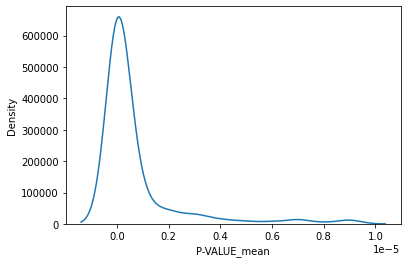

In [22]:
sns.distplot(a=snp_pval_mappedgene['P-VALUE_mean'].astype(float), hist=False)

In [23]:
# Write the SNP IDs to a text file.
# with open('ibd/all_unique_ibd_snp.txt', 'w') as f:
#     for snp in ebi_ibd_uniqueSNP:
#         f.write("%s\n" % snp)

snp_pval_mappedgene.to_csv("source_snps_ibd/snp_gwas_stats.tab", sep="\t")

### Find LD SNPs using Ensembl API

In [24]:
def ensembl_LD(snp_list):
    start_time = time.time()
    
    # Check input
    if not isinstance(snp_list, list):
        raise TypeError("The input is not a list!")
        
    # Init empty dict for storing results and list for problem URLs
    ld_snps = {"query" : [],
             "result" : [],
             "r2" : [],
             "d_prime" : []}
    problems = []
    
    # Start up the non-blocking requests
    session = FuturesSession(max_workers=10)
    futures = [session.get("https://rest.ensembl.org/ld/human/{}/1000GENOMES:phase_3:EUR?".format(snp),
                          headers={ "Content-Type" : "application/json"}) for snp in snp_list]
    
    # As the requests complete, try to parse the data into the results, otherwise report a problem URL
    for f in as_completed(futures):
        try:
            json_data = f.result().json()
            for rec in range(0, len(json_data)):
                ld_snps['query'].append(json_data[rec]['variation1'])
                ld_snps['result'].append(json_data[rec]['variation2'])
                ld_snps['r2'].append(json_data[rec]['r2'])
                ld_snps['d_prime'].append(json_data[rec]['d_prime'])
        except:
            problems.append(f.result().request.url)
            print("Found a problem. Will be requeued.")
            
    # Requeue the problem URLs in case there was a fluke
    session = FuturesSession(max_workers=8)
    futures = [session.get(url,
                          headers={ "Content-Type" : "application/json"}) for url in problems]
    problems2 = []
    for f in as_completed(futures):
        try:
            json_data = f.result().json()
            for rec in range(0, len(json_data)):
                ld_snps['query'].append(json_data[rec]['variation1'])
                ld_snps['result'].append(json_data[rec]['variation2'])
                ld_snps['r2'].append(json_data[rec]['r2'])
                ld_snps['d_prime'].append(json_data[rec]['d_prime'])
            print("Succeeded on requeue!")
        except:
            problems2.append(f.result().request.url)
            print("Failed on a requeued problem.")
            
    print("Done!")
    print("Elapsed: {0} minutes {1:0f} seconds".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
    ld_snps = pd.DataFrame.from_dict(ld_snps)
    return ld_snps, problems2

In [25]:
ld_snps, problems = ensembl_LD(ebi_ibd_uniqueSNP)

Found a problem. Will be requeued.
Failed on a requeued problem.
Done!
Elapsed: 3.0 minutes 25.227387 seconds


In [94]:
ebi_ibd_uniqueSNP.to_csv('/')

['rs4654925',
 'rs7809799',
 'rs5771069',
 'rs9268923',
 'rs6584283',
 'rs3024493',
 'rs3764147',
 'rs10761659',
 'rs1250550',
 'rs4902642',
 'rs181359',
 'rs1819658',
 'rs6556412',
 'rs2797685',
 'rs3810936',
 'rs2062305',
 'rs10495903',
 'rs212388',
 'rs7423615',
 'rs17293632',
 'rs2872507',
 'rs740495',
 'rs780093',
 'rs8005161',
 'rs11564258',
 'rs102275',
 'rs3197999',
 'rs11871801',
 'rs2413583',
 'rs4656940',
 'rs415890',
 'rs10758669',
 'rs7714584',
 'rs7554511',
 'rs12722489',
 'rs151181',
 'rs11209026',
 'rs2058660',
 'rs12720356',
 'rs7517810',
 'rs3024505',
 'rs1456896',
 'rs2838519',
 'rs12521868',
 'rs3180018',
 'rs4809330',
 'rs281379',
 'rs713875',
 'rs2549794',
 'rs13428812',
 'rs1998598',
 'rs12242110',
 'rs359457',
 'rs1799964',
 'rs4077515',
 'rs10181042',
 'rs2476601',
 'rs1893217',
 'rs11742570',
 'rs694739',
 'rs6568421',
 'rs2076756',
 'rs4409764',
 'rs6738825',
 'rs11167764',
 'rs6908425',
 'rs3091315',
 'rs3792109',
 'rs6651252',
 'rs4871611',
 'rs7927997',
 '

In [26]:
problems

['https://rest.ensembl.org/ld/human/rs10789230;%20rs11209026;%20rs1343151;%20rs6669582;%20rs10889676;%20rs11209003;%20rs12567232;%20rs11209002;%20rs11465804;%20rs10889677;%20rs2201841;%20rs1004819;%20rs9988642;%20rs2902440;%20rs2064689;%20rs11465802/1000GENOMES:phase_3:EUR']

Ok, so looks like the one that failed is a weirdo, we'll leave that one out.

I need to add the query SNPs to the table as well.

In [27]:
queries = {"query" : [],
             "result" : [],
             "r2" : [],
             "d_prime" : []}
for q in ld_snps['query'].unique():
    queries['query'].append(q)
    queries['result'].append(q)
    queries['r2'].append(1.0)
    queries['d_prime'].append(1.0)

In [28]:
ld_snps.tail()

,query,result,r2,d_prime
429507,rs1830610,rs541931562,0.294475,0.781674
429508,rs1830610,rs11793659,0.799210,0.900486
429509,rs1830610,rs2031905,0.098345,0.908825
429510,rs1830610,rs10124627,0.753301,0.891493
429511,rs1830610,rs75981045,0.094984,0.777999


In [32]:
ld_snps.to_csv("ld_expansion_ibd/ibd_cleaned_gwas_ld_snps.csv")
ld_snps = pd.read_csv("ld_expansion_ibd/ibd_cleaned_gwas_ld_snps.csv", index_col=0)
ld_snps

,query,result,r2,d_prime
0,rs34687326,rs2501346,0.082155,0.960770
1,rs34687326,rs5010834,0.097283,0.844273
2,rs34687326,rs2494515,0.064712,0.417177
3,rs34687326,rs2501350,0.079217,0.958898
4,rs34687326,rs2501341,0.084804,0.960467
...,...,...,...,...
425646,rs10781500,rs10781500,1.000000,1.000000
425647,rs10045431,rs10045431,1.000000,1.000000
425648,rs929351,rs929351,1.000000,1.000000
425649,rs9891119,rs9891119,1.000000,1.000000


In [33]:
ld_snps.r2 = ld_snps.r2.astype(float)

## Get SNP info
Now I need to get info about each SNP. This includes the coordinates, but also MAF, the allele string, etc. Again, this can be done with ENSEMBL.

Based on testing a bit, seem slike I can provide a maximum of 100 SNPs at a time. So, I'm going to have to engineer this a bit. I'll use the same Futures method as above.

In [34]:
len(ld_snps) / 100

4256.51

So, at 100 IDs per request, this would require 4257 request which is crazy. Instead, I'll filter for $R^2 \ge 0.8$ prior to searching for SNP data, which should eliminate most of those requests.

In [35]:
ld_snps_threshold = ld_snps[ld_snps.r2 >= 0.8]

In [36]:
len(ld_snps_threshold['result'].unique().tolist())/100

154.86

Great, now I only need to make 155 requests which is do-able I think.

In [59]:
def ensembl_snp_info(snp_list):
    start_time = time.time()
    
    # Check input
    if not isinstance(snp_list, list):
        raise TypeError("The input is not a list!")
        
    # Init empty dict for storing results and list for problem URLs
    result_dict = {'snp_id' : [],
              'MAF' :[],
               'minor_allele' : [],
               'consequence' : [],
              'allele_string' : [],
              'location' : [],
                  'synonyms' : []}
    problems = []
    
    # Start up the non-blocking requests in batches of 100 SNPs per request
    session = FuturesSession(max_workers=10)
    batch = 0
    futures = []
    if len(snp_list) < 100:
        futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
         headers={ "Content-Type" : "application/json",
                 "Accept" : "application/json"},
             data = json.dumps({'ids' : snp_list})))

    else:
        for i in range(0, len(snp_list)//100):
            futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
             headers={ "Content-Type" : "application/json",
                     "Accept" : "application/json"},
                 data = json.dumps({'ids' : snp_list[batch*100:(batch+1)*100]})))
            batch += 1
        
        # Add the last batch (with less than 100 IDs)
        futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
             headers={ "Content-Type" : "application/json",
                     "Accept" : "application/json"},
                 data = json.dumps({'ids' : snp_list[(batch)*100:]})))

    # As the requests complete, try to parse the data into the results_dict, otherwise report a problem URL
    n_complete = 0
    n_total = len(snp_list)
    for f in as_completed(futures):
        try:
            json_data = f.result().json()
            for key in json_data.keys():
                result_dict['snp_id'].append(key)
                result_dict['MAF'].append(json_data[key]['MAF'])
                result_dict['minor_allele'].append(json_data[key]['minor_allele'])
                result_dict['consequence'].append(json_data[key]['most_severe_consequence'])
                result_dict['allele_string'].append(json_data[key]['mappings'][0]['allele_string'])
                result_dict['location'].append(json_data[key]['mappings'][0]['location'])
                result_dict['synonyms'].append(json_data[key]['synonyms'])
                n_complete += 1
                if n_complete % 1000 == 0: # Print progress every 1000 SNPs
                    print("Completed {} / {} ids".format(n_complete, n_total))
            
        except:
            problems.append(f.result().request.url)
            print("Found a problem.")
            print("Done!")
    print("Elapsed: {0} minutes {1:0f} seconds".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
    snp_info = pd.DataFrame.from_dict(result_dict)
    return snp_info, problems

In [60]:
snp_list=ld_snps_threshold['result'].unique().tolist()
start_time = time.time()

# Check input
if not isinstance(snp_list, list):
    raise TypeError("The input is not a list!")

# Init empty dict for storing results and list for problem URLs
#     result_dict = {'snp_id' : [],
#               'MAF' :[],
#                'minor_allele' : [],
#                'consequence' : [],
#               'allele_string' : [],
#               'location' : [],
#                   'synonyms' : []}
result_dict = {}
problems = []

# Start up the non-blocking requests in batches of 100 SNPs per request
session = FuturesSession(max_workers=8)
batch = 0
futures = []

headers={"Content-Type" : "application/json",
             "Accept" : "application/json"}

if len(snp_list) < 100:
    futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
                                headers=headers,
                                data = json.dumps({'ids' : snp_list})))

else:
    for i in range(0, len(snp_list)//100):
        futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens",
                                    headers=headers,
                                    data = json.dumps({'ids' : snp_list[batch*100:(batch+1)*100]})))
        batch += 1

    # Add the last batch (with less than 100 IDs)
    futures.append(session.post("https://rest.ensembl.org/variation/homo_sapiens", 
                                headers=headers,
                                data = json.dumps({'ids' : snp_list[(batch)*100:]})))

# As the requests complete, try to parse the data into the results_dict, otherwise report a problem URL
n_complete = 0
n_total = len(snp_list)
for f in as_completed(futures):
    try:
        json_data = f.result().json()
        result_dict.update(json_data)
        n_complete += 1
        print("Finished {} of {}".format(n_complete, n_total))
#             for key in json_data.keys():
#                 result_dict['snp_id'].append(key)
#                 result_dict['MAF'].append(json_data[key]['MAF'])
#                 result_dict['minor_allele'].append(json_data[key]['minor_allele'])
#                 result_dict['consequence'].append(json_data[key]['most_severe_consequence'])
#                 result_dict['allele_string'].append(json_data[key]['mappings'][0]['allele_string'])
#                 result_dict['location'].append(json_data[key]['mappings'][0]['location'])
#                 result_dict['synonyms'].append(json_data[key]['synonyms'])
#                 n_complete += 1
#                 if n_complete % 1000 == 0: # Print progress every 1,000 SNPs
#                     print("Completed {} / {} ids".format(n_complete, n_total))

    except:
#             problems.append(json.loads(f.result().request.body)['ids'])
        problems = problems + json.loads(f.result().request.body)['ids']
        print("Found a problem.")
print("Done!")
print("Elapsed: {0} minutes {1:0f} seconds".format((time.time() - start_time) // 60, (time.time() - start_time) % 60))
#     snp_info = pd.DataFrame.from_dict(result_dict)


Finished 1 of 15486
Finished 2 of 15486
Finished 3 of 15486
Finished 4 of 15486
Finished 5 of 15486
Finished 6 of 15486
Finished 7 of 15486
Finished 8 of 15486
Finished 9 of 15486
Finished 10 of 15486
Finished 11 of 15486
Finished 12 of 15486
Finished 13 of 15486
Finished 14 of 15486
Finished 15 of 15486
Finished 16 of 15486
Finished 17 of 15486
Finished 18 of 15486
Finished 19 of 15486
Finished 20 of 15486
Finished 21 of 15486
Finished 22 of 15486
Finished 23 of 15486
Finished 24 of 15486
Finished 25 of 15486
Finished 26 of 15486
Finished 27 of 15486
Finished 28 of 15486
Finished 29 of 15486
Finished 30 of 15486
Finished 31 of 15486
Finished 32 of 15486
Finished 33 of 15486
Finished 34 of 15486
Finished 35 of 15486
Finished 36 of 15486
Finished 37 of 15486
Finished 38 of 15486
Finished 39 of 15486
Finished 40 of 15486
Finished 41 of 15486
Finished 42 of 15486
Finished 43 of 15486
Finished 44 of 15486
Finished 45 of 15486
Finished 46 of 15486
Finished 47 of 15486
Finished 48 of 15486
F

In [61]:
all_snp_info = {'snp_id' : [],
              'MAF' :[],
               'minor_allele' : [],
               'consequence' : [],
              'allele_string' : [],
              'location' : [],
                  'synonyms' : []}
for key in result_dict.keys():
    all_snp_info['snp_id'].append(key)
    all_snp_info['MAF'].append(result_dict[key]['MAF'])
    all_snp_info['minor_allele'].append(result_dict[key]['minor_allele'])
    all_snp_info['synonyms'].append(result_dict[key]['synonyms'])
    all_snp_info['consequence'].append(result_dict[key]['most_severe_consequence'])
    # Some of these have missing mappings? Or maybe it isn't a list?
    try:
        all_snp_info['allele_string'].append(result_dict[key]['mappings'][0]['allele_string'])
        all_snp_info['location'].append(result_dict[key]['mappings'][0]['location'])
    except:
        print(result_dict[key])
        all_snp_info['allele_string'].append(None)
        all_snp_info['location'].append(None)

In [62]:
len(all_snp_info['location'])

15486

In [63]:
all_snp_df = pd.DataFrame.from_dict(all_snp_info)

In [64]:
print(len(all_snp_df))
all_snp_df.head()

15486


,snp_id,MAF,minor_allele,consequence,allele_string,location,synonyms
0,rs35008389,0.1264,C,intron_variant,C/CC,1:200994408-200994408,"[rs145225242, rs141188989]"
1,rs12122721,0.1875,A,intron_variant,G/A,1:201015352-201015352,"[rs17452820, rs60618961]"
2,rs4657041,0.4357,C,intron_variant,T/C,1:161509069-161509069,[rs59129142]
3,rs7304878,0.2588,G,intron_variant,A/G,12:68092204-68092204,"[rs61005997, rs56441368]"
4,rs3829110,0.3672,G,intergenic_variant,A/G,9:136374746-136374746,[rs61391614]


So, doing a simple join using the queries and result snp_ids leaves a large number of IDs out. I tested this, and it seems to be due to synonymous SNP ids. So, I am querying a SNP, it is being found, but the ID being returned as the primary ID is different, preventing joining.

1. Ideally I would be able to use the SNP I provided in the query directly. I'm not sure if I can retrieve that from the request object or not. This would need to be possible because I am using asynchronous requests. I'll look around for this.
      - OK, so looks like this info is stored in r.request.body. *BUT, is the JSON returned in the same order as the input?*
      - NO, they are not. Probably due to something on the server side. So, I cannot use this method.

2. **Alternatively, I can retrieve the synonyms in addition to the other data, then take all of the non-joinable rows and replace their ID with whichever one of their synonyms is in our input id list.**

In [65]:
# Get the snp_info records with ids that don't match the ld_snps_threshold ids
bad_id = all_snp_df[~all_snp_df.snp_id.isin(ld_snps_threshold.result.unique())]
bad_id

,snp_id,MAF,minor_allele,consequence,allele_string,location,synonyms
13,rs34177382,0.12580,C,intron_variant,C/CC,1:200962620-200962620,"[rs113307843, rs146756791, rs147405769]"
127,rs72318718,0.24880,AAT,intron_variant,AATAAT/AAT,6:32602748-32602753,"[rs144735472, rs549968999, rs144332535, rs7767..."
161,rs9279802,0.28160,AG,intron_variant,AGAG/AG,6:32609295-32609298,"[rs67920507, rs67920506, rs572175875]"
176,rs623327,0.25740,A,intron_variant,C/A/G/T,6:32602302-32602302,"[rs9270825, rs28383176, rs75208983, rs6920721]"
217,rs35036050,0.30550,-,intron_variant,TTTTTTTTTTTTTTTTT/TTTTTTTTTT/TTTTTTTTTTTTT/TTT...,22:21597965-21597981,"[rs1481275641, rs1305724748, rs530685161, rs13..."
...,...,...,...,...,...,...,...
15355,rs60391241,0.41690,TCCACC,intron_variant,TCCACCTCCACCT/TCCACCT,17:59891369-59891381,"[rs146124121, rs72300687]"
15356,rs34781420,0.04672,A,intron_variant,AAAA/AAAAA,6:111580051-111580054,"[rs111518603, rs140064396, rs371668720, rs1442..."
15413,rs34065870,0.25340,-,intron_variant,CTTTTTCAACTTTT/CTTTT/CTTTTTCAACTTTTTCAACTTTT,3:111779253-111779266,"[rs140283879, rs745704304, rs61443630]"
15456,rs34066334,0.39620,GG,intergenic_variant,GGGGGGGGGG/GGGGGGG/GGGGGGGG/GGGGGGGGG/GGGGGGGG...,6:116473786-116473795,"[rs149460260, rs72589918, rs374279254, rs59514..."


In [66]:
target_ids = ld_snps_threshold.result.unique()
for ix, row in bad_id.iterrows():
    for synonym in row['synonyms']:
        if synonym in target_ids:
            all_snp_df.loc[ix, 'snp_id'] = synonym

In [67]:
# See how many bad ids are left
len(all_snp_df[~all_snp_df.snp_id.isin(ld_snps_threshold.result.unique())])

0

Great! Seems like it worked. Now let's find out for sure - can we successfully join the `snp_info` dataframe with our `ld_snps_threshold` dataframe?

- *I just considered the possibility that some of our "unique" snps used as input might be synonyms of eachother... If so, we'll see some blank records.*

In [68]:
len(ld_snps_threshold)

27894

In [69]:
ld_snps_with_info = ld_snps_threshold.merge(all_snp_df, left_on='result', right_on='snp_id', how='left')
ld_snps_with_info

,query,result,r2,d_prime,snp_id,MAF,minor_allele,consequence,allele_string,location,synonyms
0,rs6740462,rs268124,0.980167,0.994978,rs268124,0.3097,C,intron_variant,C/G/T,2:65427230-65427230,[rs57584396]
1,rs12942547,rs8071537,0.800839,0.999999,rs8071537,0.3800,T,intron_variant,G/T,17:42378877-42378877,[rs74252738]
2,rs12942547,rs8073517,0.810302,0.995154,rs8073517,0.4872,T,intron_variant,T/A/C,17:42351306-42351306,"[rs58198616, rs17881243]"
3,rs12942547,rs35840966,0.814715,0.999999,rs35840966,0.3920,T,intron_variant,C/T,17:42369186-42369186,[rs62075776]
4,rs12942547,rs12949918,0.979611,0.995859,rs12949918,0.3978,C,intron_variant,T/C,17:42374255-42374255,"[rs17593376, rs17880714]"
...,...,...,...,...,...,...,...,...,...,...,...
27889,rs10781500,rs10781500,1.000000,1.000000,rs10781500,0.3670,T,intergenic_variant,C/A/G/T,9:136374886-136374886,[rs61181950]
27890,rs10045431,rs10045431,1.000000,1.000000,rs10045431,0.1508,A,intron_variant,A/C/T,5:159387525-159387525,"[rs11135060, rs59372928]"
27891,rs929351,rs929351,1.000000,1.000000,rs929351,0.3211,G,intron_variant,T/G,7:82228577-82228577,"[rs17176168, rs58914784, rs41453145]"
27892,rs9891119,rs9891119,1.000000,1.000000,rs9891119,0.3932,C,intron_variant,A/C/G/T,17:42355962-42355962,[rs59868688]


In [70]:
ld_snps_with_info[ld_snps_with_info.location.isna()]
# ld_snps_with_info[ld_snps_with_info.result=='rs67963613']

,query,result,r2,d_prime,snp_id,MAF,minor_allele,consequence,allele_string,location,synonyms


Perfect! Problem solved. All of our LD snps now have location information, and probably most of the other fields as well.

Now let's turn that location column into something we can convert to BED format.

In [71]:
coords = ld_snps_with_info['location'].str.split(r":|-", expand=True)
ld_snps_with_info['chrom'], ld_snps_with_info['start'], ld_snps_with_info['end'] = 'chr' + coords[0], coords[1], coords[2]
ld_snps_with_info.drop(columns=['location'], inplace=True)

In [72]:
ld_snps_with_info.head()

,query,result,r2,d_prime,snp_id,MAF,minor_allele,consequence,allele_string,synonyms,chrom,start,end
0,rs6740462,rs268124,0.980167,0.994978,rs268124,0.3097,C,intron_variant,C/G/T,[rs57584396],chr2,65427230,65427230
1,rs12942547,rs8071537,0.800839,0.999999,rs8071537,0.3800,T,intron_variant,G/T,[rs74252738],chr17,42378877,42378877
2,rs12942547,rs8073517,0.810302,0.995154,rs8073517,0.4872,T,intron_variant,T/A/C,"[rs58198616, rs17881243]",chr17,42351306,42351306
3,rs12942547,rs35840966,0.814715,0.999999,rs35840966,0.3920,T,intron_variant,C/T,[rs62075776],chr17,42369186,42369186
4,rs12942547,rs12949918,0.979611,0.995859,rs12949918,0.3978,C,intron_variant,T/C,"[rs17593376, rs17880714]",chr17,42374255,42374255


In [73]:
# Save the snp_info to a file
ld_snps_with_info.to_csv('ld_expansion_ibd/ld_snps_info_new.tab', sep='\t', index=False)

In [157]:
ld_snps_with_info = pd.read_table("ld_expansion_ibd/ld_snps_info_new.tab")

In [158]:
ld_snps_info_gwas = ld_snps_with_info.merge(snp_pval_mappedgene, left_on='query', right_on='SNPS_', how='left')

In [159]:
ld_snps_info_gwas = ld_snps_info_gwas[['query', 'snp_id', 'r2', 'd_prime', 'MAF', 'minor_allele',
       'consequence', 'allele_string', 'synonyms', 'chrom', 'start', 'end',
       'P-VALUE_mean', 'P-VALUE_listed', 'REPORTED GENE(S)_listed',
       'MAPPED_GENE_listed']]

In [160]:
ld_snps_info_gwas.to_csv('ld_expansion_ibd/ld_snps_info_gwas_new.tab', sep='\t', index=False)

How many SNPs fall into each of the "consquence" categories?

In [161]:
ld_snps_info_gwas

,query,snp_id,r2,d_prime,MAF,minor_allele,consequence,allele_string,synonyms,chrom,start,end,P-VALUE_mean,P-VALUE_listed,REPORTED GENE(S)_listed,MAPPED_GENE_listed
0,rs6740462,rs268124,0.980167,0.994978,0.3097,C,intron_variant,C/G/T,['rs57584396'],chr2,65427230,65427230,5.050020e-07,"[2e-12, 6e-12, 2e-08, 2e-06]","[NR, NR, SPRED2, SPRED2]","[AC007389.1, AC012370.2, AC007389.1, AC012370...."
1,rs12942547,rs8071537,0.800839,0.999999,0.3800,T,intron_variant,G/T,['rs74252738'],chr17,42378877,42378877,3.128572e-10,"[7e-11, 1e-16, 6e-22, 1e-10, 2e-11, 2e-17, 2e-09]","[NR, NR, STAT3, STAT5B, STAT5A, NAGLU, STAT5A,...","[STAT3, STAT3, STAT3, STAT3, STAT3, STAT3, STAT3]"
2,rs12942547,rs8073517,0.810302,0.995154,0.4872,T,intron_variant,T/A/C,"['rs58198616', 'rs17881243']",chr17,42351306,42351306,3.128572e-10,"[7e-11, 1e-16, 6e-22, 1e-10, 2e-11, 2e-17, 2e-09]","[NR, NR, STAT3, STAT5B, STAT5A, NAGLU, STAT5A,...","[STAT3, STAT3, STAT3, STAT3, STAT3, STAT3, STAT3]"
3,rs12942547,rs35840966,0.814715,0.999999,0.3920,T,intron_variant,C/T,['rs62075776'],chr17,42369186,42369186,3.128572e-10,"[7e-11, 1e-16, 6e-22, 1e-10, 2e-11, 2e-17, 2e-09]","[NR, NR, STAT3, STAT5B, STAT5A, NAGLU, STAT5A,...","[STAT3, STAT3, STAT3, STAT3, STAT3, STAT3, STAT3]"
4,rs12942547,rs12949918,0.979611,0.995859,0.3978,C,intron_variant,T/C,"['rs17593376', 'rs17880714']",chr17,42374255,42374255,3.128572e-10,"[7e-11, 1e-16, 6e-22, 1e-10, 2e-11, 2e-17, 2e-09]","[NR, NR, STAT3, STAT5B, STAT5A, NAGLU, STAT5A,...","[STAT3, STAT3, STAT3, STAT3, STAT3, STAT3, STAT3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27889,rs10781500,rs10781500,1.000000,1.000000,0.3670,T,intergenic_variant,C/A/G/T,['rs61181950'],chr9,136374886,136374886,7.000000e-06,[7e-06],[CARD9],[CARD9 - SNAPC4]
27890,rs10045431,rs10045431,1.000000,1.000000,0.1508,A,intron_variant,A/C/T,"['rs11135060', 'rs59372928']",chr5,159387525,159387525,3.500020e-08,"[7e-08, 4e-13]","[IL12B, IL12B]","[AC008691.1, AC008691.1]"
27891,rs929351,rs929351,1.000000,1.000000,0.3211,G,intron_variant,T/G,"['rs17176168', 'rs58914784', 'rs41453145']",chr7,82228577,82228577,8.000000e-06,[8e-06],[CACNA2D1],[CACNA2D1]
27892,rs9891119,rs9891119,1.000000,1.000000,0.3932,C,intron_variant,A/C/G/T,['rs59868688'],chr17,42355962,42355962,2.000000e-15,[2e-15],[STAT3],[STAT3]


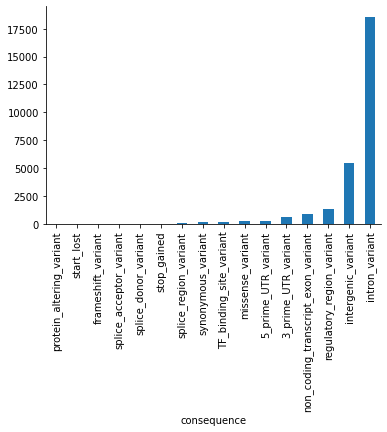

In [162]:
ld_snps_with_info.groupby('consequence').size().sort_values().plot(kind='bar')
sns.despine()

How many SNPs are on each chromosome?

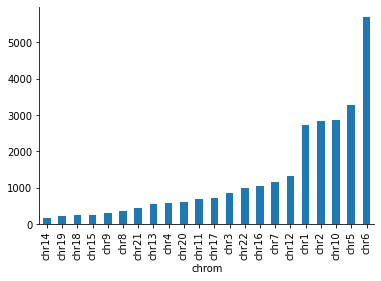

In [163]:
ld_snps_with_info.groupby('chrom').size().sort_values().plot(kind='bar')
sns.despine()

In [164]:
def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [165]:
sorted_nicely(ld_snps_with_info.chrom.unique())

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr20',
 'chr21',
 'chr22']

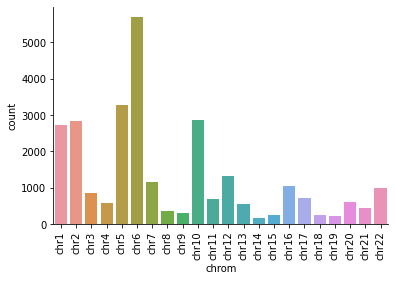

In [82]:
sns.countplot(data=ld_snps_with_info, x = 'chrom', order=sorted_nicely(ld_snps_with_info.chrom.unique()))
plt.xticks(rotation=90)
sns.despine()

So, you might expect that the number of SNPs per chromosome is correlated with chromosome size (it is, but only slightly, which indicates that IBD-associated SNPs are non-random, which makes sense). However, why are there so many more SNPs on chr6?

Simple answer: the HLA locus is on chromosome 6!

Now I'll export the SNPs as a BED file for the next step in analysis.

There are some odd rows which are unusual in that the end coordinate is smaller than the start, which is not valid BED. This is due to deletions, and is ok, but I'll need to remedy that.

In [83]:
ld_snps_with_info.head()

,query,result,r2,d_prime,snp_id,MAF,minor_allele,consequence,allele_string,synonyms,chrom,start,end
0,rs6740462,rs268124,0.980167,0.994978,rs268124,0.3097,C,intron_variant,C/G/T,['rs57584396'],chr2,65427230,65427230
1,rs12942547,rs8071537,0.800839,0.999999,rs8071537,0.3800,T,intron_variant,G/T,['rs74252738'],chr17,42378877,42378877
2,rs12942547,rs8073517,0.810302,0.995154,rs8073517,0.4872,T,intron_variant,T/A/C,"['rs58198616', 'rs17881243']",chr17,42351306,42351306
3,rs12942547,rs35840966,0.814715,0.999999,rs35840966,0.3920,T,intron_variant,C/T,['rs62075776'],chr17,42369186,42369186
4,rs12942547,rs12949918,0.979611,0.995859,rs12949918,0.3978,C,intron_variant,T/C,"['rs17593376', 'rs17880714']",chr17,42374255,42374255


In [84]:
ld_to_bed = ld_snps_with_info[['chrom', 'start']].copy()
ld_to_bed['end'] = ld_to_bed['start']
ld_to_bed['start'] = ld_to_bed['start'].astype(int) - 1 # Convert to 0-based coordinates
ld_to_bed['name'] = ld_snps_with_info['snp_id']
ld_to_bed = ld_to_bed.drop_duplicates()

In [85]:
ld_to_bed.to_csv("ld_expansion_ibd/ibd_ld_snps_r2_0.8_new.bed", sep="\t", header=None, index=None)

In [89]:
!sort -k1,1 -k2,2n ld_expansion_ibd/ibd_ld_snps_r2_0.8_new.bed > ld_expansion_ibd/ibd_ld_snps_r2_0.8_new.sorted.bed

### Find LD SNPs using NCBI's LDlink

Because of this formatting error, we're going to try a different method of getting SNPs in LD. NCBI provides an "LDlink" tool which will allow us to find all of the LD SNPs for a given query variant. I registered for an API token so we can now use HTTP requests to programmatically obtain all of the SNPs in LD. Biggest downside to this tool is that the genome build is hg19(GRCh37) and the MS SNPs are hg38 (*i think*). << **WRONG**. They are hg19.

In [90]:
import requests
import time
from io import StringIO
api_token = 'bb2472bededc'

In [91]:
snp_id = 'rs12443971'
payload = {'token' : api_token,
          'var' : snp_id,
          'pop' : 'EUR',
          'r2_d' : 'r2'}

In [92]:
def getLD(snps):
    '''Takes a list of SNP rsIDs or hg19 coordinates and returns all of the SNPs in LD'''
    st_time = time.time()
    api_token = 'bb2472bededc'
    problem_ids = []
    begin = 0
    for i, snp in enumerate(snps):
        payload = {'token' : api_token, # Dict of params for HTTP request
          'var' : snp,
          'pop' : 'EUR',
          'r2_d' : 'r2'}
        r = requests.get('https://ldlink.nci.nih.gov/LDlinkRest/ldproxy', params=payload) # Make HTTP request
        if "traceback" in str(r.content):
            problem_ids.append(snp)
            print("SNP %s was not found! Skipping..." % (snp))
            if i == begin:
                begin += 1
                ld_snps = []
        elif i == begin: # If the first query, instantiate the results df
            ld_snps = pd.read_table(StringIO(str(r.content, 'utf-8'))) # Parse the bytestring into a pandas DF
            ld_snps['Query'] = snp
        else: # If not the first query, add onto the existing results df
            more_snps = pd.read_table(StringIO(str(r.content, 'utf-8')))
            more_snps['Query'] = snp
            ld_snps = pd.concat(objs=[ld_snps, more_snps])
        print(time.ctime())
        print("Completed %d / %d SNPs!" % (i+1, len(snps))) # Progress reporting for sanity
        print("Total: %d linked SNPs" % (len(ld_snps)))
        print("Elapsed: %d minutes %d seconds" % (np.floor((time.time() - st_time)/60), (time.time() - st_time)%60))
        print("")
    return ld_snps, problem_ids

Josh uses **all_unique_SNP** file to expand on using LD using NCBI LDlink. But I couldn't find any file or variable with the name all_unique_SNP. It made sense logically to use the unique set of SNPs identified for IBD from EBI (that was used for GWAS LD exapnsion) to be also used as the input file for the NCBI LDLink expansion. Hence I am using **ebi_ibs_uniqueSNP** for the NCBI LDlink expansion of SNPs. <br>
The only concern here is the file **all_unique_snp** has only 531 entries while the file **ebi_ibd_uniqueSNP** has 665 entries

In [95]:
len(ebi_ibd_uniqueSNP)

665

In [102]:
### DO NOT RUN THIS AGAIN! It takes > 2 hours to complete.
all_LD, problem_ids = getLD(ebi_ibd_uniqueSNP)

SNP rs4654925 was not found! Skipping...
Mon Jun 28 11:00:30 2021
Completed 1 / 665 SNPs!
Total: 0 linked SNPs
Elapsed: 0 minutes 0 seconds

Mon Jun 28 11:00:37 2021
Completed 2 / 665 SNPs!
Total: 1352 linked SNPs
Elapsed: 0 minutes 7 seconds

Mon Jun 28 11:00:45 2021
Completed 3 / 665 SNPs!
Total: 2563 linked SNPs
Elapsed: 0 minutes 15 seconds

Mon Jun 28 11:01:03 2021
Completed 4 / 665 SNPs!
Total: 19706 linked SNPs
Elapsed: 0 minutes 34 seconds

Mon Jun 28 11:01:10 2021
Completed 5 / 665 SNPs!
Total: 20588 linked SNPs
Elapsed: 0 minutes 40 seconds

Mon Jun 28 11:01:17 2021
Completed 6 / 665 SNPs!
Total: 21143 linked SNPs
Elapsed: 0 minutes 47 seconds

Mon Jun 28 11:01:24 2021
Completed 7 / 665 SNPs!
Total: 22293 linked SNPs
Elapsed: 0 minutes 54 seconds

Mon Jun 28 11:01:31 2021
Completed 8 / 665 SNPs!
Total: 23669 linked SNPs
Elapsed: 1 minutes 1 seconds

Mon Jun 28 11:01:38 2021
Completed 9 / 665 SNPs!
Total: 24251 linked SNPs
Elapsed: 1 minutes 8 seconds

Mon Jun 28 11:01:45 2021

Mon Jun 28 11:11:06 2021
Completed 79 / 665 SNPs!
Total: 107763 linked SNPs
Elapsed: 10 minutes 37 seconds

Mon Jun 28 11:11:19 2021
Completed 80 / 665 SNPs!
Total: 112422 linked SNPs
Elapsed: 10 minutes 49 seconds

Mon Jun 28 11:11:27 2021
Completed 81 / 665 SNPs!
Total: 113188 linked SNPs
Elapsed: 10 minutes 57 seconds

Mon Jun 28 11:11:34 2021
Completed 82 / 665 SNPs!
Total: 114260 linked SNPs
Elapsed: 11 minutes 4 seconds

Mon Jun 28 11:11:41 2021
Completed 83 / 665 SNPs!
Total: 115188 linked SNPs
Elapsed: 11 minutes 11 seconds

Mon Jun 28 11:11:49 2021
Completed 84 / 665 SNPs!
Total: 116542 linked SNPs
Elapsed: 11 minutes 19 seconds

Mon Jun 28 11:11:55 2021
Completed 85 / 665 SNPs!
Total: 117449 linked SNPs
Elapsed: 11 minutes 26 seconds

Mon Jun 28 11:12:09 2021
Completed 86 / 665 SNPs!
Total: 120784 linked SNPs
Elapsed: 11 minutes 39 seconds

Mon Jun 28 11:12:16 2021
Completed 87 / 665 SNPs!
Total: 121500 linked SNPs
Elapsed: 11 minutes 46 seconds

Mon Jun 28 11:12:22 2021
Comp

Mon Jun 28 11:21:45 2021
Completed 154 / 665 SNPs!
Total: 304721 linked SNPs
Elapsed: 21 minutes 15 seconds

Mon Jun 28 11:21:52 2021
Completed 155 / 665 SNPs!
Total: 306538 linked SNPs
Elapsed: 21 minutes 23 seconds

Mon Jun 28 11:22:00 2021
Completed 156 / 665 SNPs!
Total: 307001 linked SNPs
Elapsed: 21 minutes 30 seconds

Mon Jun 28 11:22:08 2021
Completed 157 / 665 SNPs!
Total: 308830 linked SNPs
Elapsed: 21 minutes 38 seconds

Mon Jun 28 11:22:15 2021
Completed 158 / 665 SNPs!
Total: 309420 linked SNPs
Elapsed: 21 minutes 45 seconds

Mon Jun 28 11:22:22 2021
Completed 159 / 665 SNPs!
Total: 310706 linked SNPs
Elapsed: 21 minutes 52 seconds

Mon Jun 28 11:22:30 2021
Completed 160 / 665 SNPs!
Total: 311684 linked SNPs
Elapsed: 22 minutes 0 seconds

Mon Jun 28 11:22:37 2021
Completed 161 / 665 SNPs!
Total: 312588 linked SNPs
Elapsed: 22 minutes 8 seconds

Mon Jun 28 11:22:57 2021
Completed 162 / 665 SNPs!
Total: 328088 linked SNPs
Elapsed: 22 minutes 27 seconds

Mon Jun 28 11:23:05 2

Mon Jun 28 11:31:47 2021
Completed 229 / 665 SNPs!
Total: 430310 linked SNPs
Elapsed: 31 minutes 17 seconds

SNP rs4820425 was not found! Skipping...
Mon Jun 28 11:31:48 2021
Completed 230 / 665 SNPs!
Total: 430310 linked SNPs
Elapsed: 31 minutes 18 seconds

Mon Jun 28 11:32:02 2021
Completed 231 / 665 SNPs!
Total: 434616 linked SNPs
Elapsed: 31 minutes 32 seconds

Mon Jun 28 11:32:10 2021
Completed 232 / 665 SNPs!
Total: 435622 linked SNPs
Elapsed: 31 minutes 40 seconds

Mon Jun 28 11:32:18 2021
Completed 233 / 665 SNPs!
Total: 438437 linked SNPs
Elapsed: 31 minutes 48 seconds

Mon Jun 28 11:32:27 2021
Completed 234 / 665 SNPs!
Total: 439524 linked SNPs
Elapsed: 31 minutes 58 seconds

Mon Jun 28 11:32:34 2021
Completed 235 / 665 SNPs!
Total: 441149 linked SNPs
Elapsed: 32 minutes 4 seconds

Mon Jun 28 11:32:41 2021
Completed 236 / 665 SNPs!
Total: 441823 linked SNPs
Elapsed: 32 minutes 11 seconds

Mon Jun 28 11:32:50 2021
Completed 237 / 665 SNPs!
Total: 443473 linked SNPs
Elapsed: 32

Mon Jun 28 11:42:23 2021
Completed 304 / 665 SNPs!
Total: 600962 linked SNPs
Elapsed: 41 minutes 53 seconds

Mon Jun 28 11:42:31 2021
Completed 305 / 665 SNPs!
Total: 602762 linked SNPs
Elapsed: 42 minutes 1 seconds

Mon Jun 28 11:42:39 2021
Completed 306 / 665 SNPs!
Total: 603717 linked SNPs
Elapsed: 42 minutes 9 seconds

Mon Jun 28 11:42:46 2021
Completed 307 / 665 SNPs!
Total: 605061 linked SNPs
Elapsed: 42 minutes 16 seconds

Mon Jun 28 11:42:53 2021
Completed 308 / 665 SNPs!
Total: 606602 linked SNPs
Elapsed: 42 minutes 24 seconds

Mon Jun 28 11:43:00 2021
Completed 309 / 665 SNPs!
Total: 607768 linked SNPs
Elapsed: 42 minutes 31 seconds

Mon Jun 28 11:43:08 2021
Completed 310 / 665 SNPs!
Total: 608704 linked SNPs
Elapsed: 42 minutes 38 seconds

Mon Jun 28 11:43:15 2021
Completed 311 / 665 SNPs!
Total: 608940 linked SNPs
Elapsed: 42 minutes 45 seconds

Mon Jun 28 11:43:22 2021
Completed 312 / 665 SNPs!
Total: 609972 linked SNPs
Elapsed: 42 minutes 52 seconds

Mon Jun 28 11:43:30 2

Mon Jun 28 11:51:38 2021
Completed 379 / 665 SNPs!
Total: 690518 linked SNPs
Elapsed: 51 minutes 8 seconds

Mon Jun 28 11:51:45 2021
Completed 380 / 665 SNPs!
Total: 691143 linked SNPs
Elapsed: 51 minutes 15 seconds

Mon Jun 28 11:51:53 2021
Completed 381 / 665 SNPs!
Total: 692265 linked SNPs
Elapsed: 51 minutes 23 seconds

Mon Jun 28 11:52:00 2021
Completed 382 / 665 SNPs!
Total: 693054 linked SNPs
Elapsed: 51 minutes 30 seconds

Mon Jun 28 11:52:07 2021
Completed 383 / 665 SNPs!
Total: 694498 linked SNPs
Elapsed: 51 minutes 38 seconds

Mon Jun 28 11:52:14 2021
Completed 384 / 665 SNPs!
Total: 695576 linked SNPs
Elapsed: 51 minutes 44 seconds

Mon Jun 28 11:52:21 2021
Completed 385 / 665 SNPs!
Total: 697000 linked SNPs
Elapsed: 51 minutes 51 seconds

Mon Jun 28 11:52:28 2021
Completed 386 / 665 SNPs!
Total: 698482 linked SNPs
Elapsed: 51 minutes 59 seconds

Mon Jun 28 11:52:35 2021
Completed 387 / 665 SNPs!
Total: 699567 linked SNPs
Elapsed: 52 minutes 6 seconds

Mon Jun 28 11:52:42 2

Mon Jun 28 12:01:27 2021
Completed 455 / 665 SNPs!
Total: 784618 linked SNPs
Elapsed: 60 minutes 57 seconds

Mon Jun 28 12:01:35 2021
Completed 456 / 665 SNPs!
Total: 786167 linked SNPs
Elapsed: 61 minutes 5 seconds

Mon Jun 28 12:01:42 2021
Completed 457 / 665 SNPs!
Total: 787074 linked SNPs
Elapsed: 61 minutes 13 seconds

Mon Jun 28 12:01:50 2021
Completed 458 / 665 SNPs!
Total: 787546 linked SNPs
Elapsed: 61 minutes 20 seconds

Mon Jun 28 12:01:58 2021
Completed 459 / 665 SNPs!
Total: 789701 linked SNPs
Elapsed: 61 minutes 29 seconds

Mon Jun 28 12:02:06 2021
Completed 460 / 665 SNPs!
Total: 791912 linked SNPs
Elapsed: 61 minutes 36 seconds

Mon Jun 28 12:02:13 2021
Completed 461 / 665 SNPs!
Total: 792632 linked SNPs
Elapsed: 61 minutes 44 seconds

Mon Jun 28 12:02:20 2021
Completed 462 / 665 SNPs!
Total: 794384 linked SNPs
Elapsed: 61 minutes 50 seconds

Mon Jun 28 12:02:28 2021
Completed 463 / 665 SNPs!
Total: 795475 linked SNPs
Elapsed: 61 minutes 58 seconds

Mon Jun 28 12:02:36 

Mon Jun 28 12:11:02 2021
Completed 531 / 665 SNPs!
Total: 870114 linked SNPs
Elapsed: 70 minutes 32 seconds

Mon Jun 28 12:11:11 2021
Completed 532 / 665 SNPs!
Total: 871099 linked SNPs
Elapsed: 70 minutes 41 seconds

Mon Jun 28 12:11:17 2021
Completed 533 / 665 SNPs!
Total: 872361 linked SNPs
Elapsed: 70 minutes 48 seconds

Mon Jun 28 12:11:25 2021
Completed 534 / 665 SNPs!
Total: 874252 linked SNPs
Elapsed: 70 minutes 55 seconds

Mon Jun 28 12:11:32 2021
Completed 535 / 665 SNPs!
Total: 874921 linked SNPs
Elapsed: 71 minutes 3 seconds

Mon Jun 28 12:11:39 2021
Completed 536 / 665 SNPs!
Total: 876472 linked SNPs
Elapsed: 71 minutes 9 seconds

Mon Jun 28 12:11:46 2021
Completed 537 / 665 SNPs!
Total: 878231 linked SNPs
Elapsed: 71 minutes 17 seconds

Mon Jun 28 12:11:53 2021
Completed 538 / 665 SNPs!
Total: 879176 linked SNPs
Elapsed: 71 minutes 23 seconds

Mon Jun 28 12:12:01 2021
Completed 539 / 665 SNPs!
Total: 881156 linked SNPs
Elapsed: 71 minutes 31 seconds

Mon Jun 28 12:12:08 2

Mon Jun 28 12:21:30 2021
Completed 605 / 665 SNPs!
Total: 1039344 linked SNPs
Elapsed: 81 minutes 1 seconds

SNP rs140068907 was not found! Skipping...
Mon Jun 28 12:21:32 2021
Completed 606 / 665 SNPs!
Total: 1039344 linked SNPs
Elapsed: 81 minutes 2 seconds

Mon Jun 28 12:21:39 2021
Completed 607 / 665 SNPs!
Total: 1039661 linked SNPs
Elapsed: 81 minutes 9 seconds

Mon Jun 28 12:21:48 2021
Completed 608 / 665 SNPs!
Total: 1041183 linked SNPs
Elapsed: 81 minutes 18 seconds

Mon Jun 28 12:21:55 2021
Completed 609 / 665 SNPs!
Total: 1041711 linked SNPs
Elapsed: 81 minutes 25 seconds

Mon Jun 28 12:22:03 2021
Completed 610 / 665 SNPs!
Total: 1042355 linked SNPs
Elapsed: 81 minutes 33 seconds

Mon Jun 28 12:22:11 2021
Completed 611 / 665 SNPs!
Total: 1044223 linked SNPs
Elapsed: 81 minutes 41 seconds

Mon Jun 28 12:22:19 2021
Completed 612 / 665 SNPs!
Total: 1045473 linked SNPs
Elapsed: 81 minutes 49 seconds

Mon Jun 28 12:22:26 2021
Completed 613 / 665 SNPs!
Total: 1045594 linked SNPs
El

In [103]:
all_LD.to_csv("all_LD_IBD_SNPs.tab", sep="\t")

In [104]:
all_LD.to_pickle("all_LD_IBD_SNPs.pkl")

In [105]:
all_LD = pd.read_pickle("all_LD_IBD_SNPs.pkl")

In [106]:
all_LD.head()

,RS_Number,Coord,Alleles,MAF,Distance,Dprime,R2,Correlated_Alleles,RegulomeDB,Function,Query
0,rs7809799,chr7:98760504,(G/A),0.0616,0,1.0,1.0000,"G=G,A=A",4,NaN,rs7809799
1,rs2395051,chr7:98761201,(A/G),0.0606,697,1.0,0.9828,"G=A,A=G",6,NaN,rs7809799
2,rs4729517,chr7:98761961,(G/A),0.0606,1457,1.0,0.9828,"G=G,A=A",7,NaN,rs7809799
3,rs6962075,chr7:98757940,(A/G),0.0606,-2564,1.0,0.9828,"G=A,A=G",7,NaN,rs7809799
4,rs6961749,chr7:98757715,(C/T),0.0606,-2789,1.0,0.9828,"G=C,A=T",7,NaN,rs7809799


### How do the ENSEMBL and LDLINK methods compare?
It turns out that the ENSEMBL database has a 500 kb "window size" whereas LDlink uses a window that is "500 kb +/- of the query"

As a result, LDlink pulls almost twice as many raw SNPs. However, when we filter for R2 >= 0.8, they are extremely comparable.

What are the differences?

The LDlink approach finds 929 SNPs not found by the ENSEMBL method
ENSEMBL method finds 990 SNPs not found by LDlink method.

In [107]:
from matplotlib_venn import venn2

In [108]:
ens_ld_unique = set(np.unique(ld_snps.loc[ld_snps.r2 >= 0.8, 'result'].tolist() + ld_snps['query'].tolist()))
ldlink_unique = set(all_LD.loc[all_LD.R2 >= 0.8,'RS_Number'].unique().tolist())
# np.setdiff1d(ens_ld_unique, ldlink_unique, assume_unique=True)
print(len(ens_ld_unique))
print(len(ldlink_unique))


15486
15336


In [109]:
print(len(ldlink_unique - ens_ld_unique))
print(len(ens_ld_unique - ldlink_unique))

1067
1217


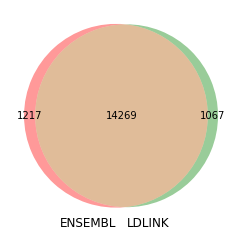

In [110]:
venn2([ens_ld_unique, ldlink_unique], ('ENSEMBL', 'LDLINK'))
plt.show()

Why the difference? Maybe the ones found by LDlink are more than 250 kb away from the query...

ALSO. Turns out LDlink adds the query to the results automatically. So, simply including that boosted ENSEMBL.

In [153]:
problems # These coordinates are hg19

[]

In [112]:
ldlink_unique - ens_ld_unique

{'rs113869582',
 'rs113854494',
 'rs34846641',
 'rs62543573',
 'rs10539398',
 'rs3117115',
 'rs114125694',
 'rs117217399',
 'rs67150692',
 'rs7241016',
 'rs3811699',
 'rs56271737',
 'rs7860987',
 'rs3780370',
 'rs77032596',
 'rs6476947',
 'rs11716974',
 'rs352388',
 'rs13324950',
 'rs41278164',
 'rs12684720',
 'rs2823264',
 'rs6446264',
 'rs11715177',
 'rs34780156',
 'rs9871380',
 'rs2595398',
 'rs56280080',
 'rs484020',
 'rs12351715',
 'rs114645460',
 'rs10854382',
 'rs770667',
 'rs4822052',
 'rs141823809',
 'rs10975031',
 'rs10694919',
 'rs2823254',
 'rs117017165',
 'rs333',
 'rs66718836',
 'rs2682857',
 'rs181774311',
 'rs72530217',
 'rs34127330',
 'rs1855186',
 'rs2823265',
 'rs5786460',
 'rs76637837',
 'rs2594701',
 'rs34906309',
 'rs34488542',
 'rs77051751',
 'rs9468848',
 'rs10974975',
 'rs139721559',
 'rs2209774',
 'rs35533149',
 'rs80273660',
 'rs487273',
 'rs7038687',
 'rs9272737',
 'rs111340803',
 'rs11398183',
 'rs11054957',
 'rs467615',
 'rs55666589',
 'rs7857081',
 'rs114

In [113]:
all_LD = all_LD.reset_index(drop=True)
all_LD[((all_LD.R2 >= 0.8) & all_LD.RS_Number.isin(ldlink_unique - ens_ld_unique))]

,RS_Number,Coord,Alleles,MAF,Distance,Dprime,R2,Correlated_Alleles,RegulomeDB,Function,Query
28,.,chr7:98757641,(T/G),0.0596,-2863,1.0000,0.9657,"G=G,A=T",.,.,rs7809799
36,rs143332463,chr7:98781018,(-/AA),0.0596,20514,1.0000,0.9657,"G=AA,A=-",.,NaN,rs7809799
2564,rs33936419,chr6:32432992,(-/T),0.3211,157,1.0000,1.0000,"C=-,T=T",.,NaN,rs9268923
2576,.,chr6:32435550,(G/A),0.3211,2715,1.0000,1.0000,"C=G,T=A",7,.,rs9268923
2588,.,chr6:32441391,(-/T),0.3211,8556,1.0000,1.0000,"C=-,T=T",4,.,rs9268923
...,...,...,...,...,...,...,...,...,...,...,...
1096013,rs12340866,chr9:5094185,(G/A),0.2883,-165894,0.9027,0.8031,"C=G,T=A",7,NaN,rs1830610
1096014,rs10117459,chr9:5094034,(G/A),0.2883,-166045,0.9027,0.8031,"C=G,T=A",5,NaN,rs1830610
1096015,rs146385350,chr9:5090966,(TTG/-),0.2883,-169113,0.9027,0.8031,"C=TTG,T=-",.,NaN,rs1830610
1096016,rs2274649,chr9:5090934,(A/T),0.2883,-169145,0.9027,0.8031,"C=A,T=T",7,NaN,rs1830610


# FIX THE hg38 COORDINATE INPUT SNPS

All of the SNPs that were input as chromosomal coordinates instead of rs numbers may be incorrect, ~~because they were hg38 coordinates and LDlink works with hg19 coordinates~~. **Actually, these are hg19 to begin with.** Therefore, we will now correct that subset of SNPs. There are only 20 of these, so should be easy to reprocess.

In [114]:
def linkagePlots(df):
    f, ax = plt.subplots(1,3, sharey=False, figsize=(12,4), dpi=300)
    sns.distplot(df.R2, ax = ax[0])
    sns.distplot(df.Dprime, ax=ax[1])
    sns.scatterplot(x=df.R2, y=df.Dprime, ax=ax[2], markers=".")
    f.tight_layout()

What is the typical distance of the LD SNPs from the query?

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


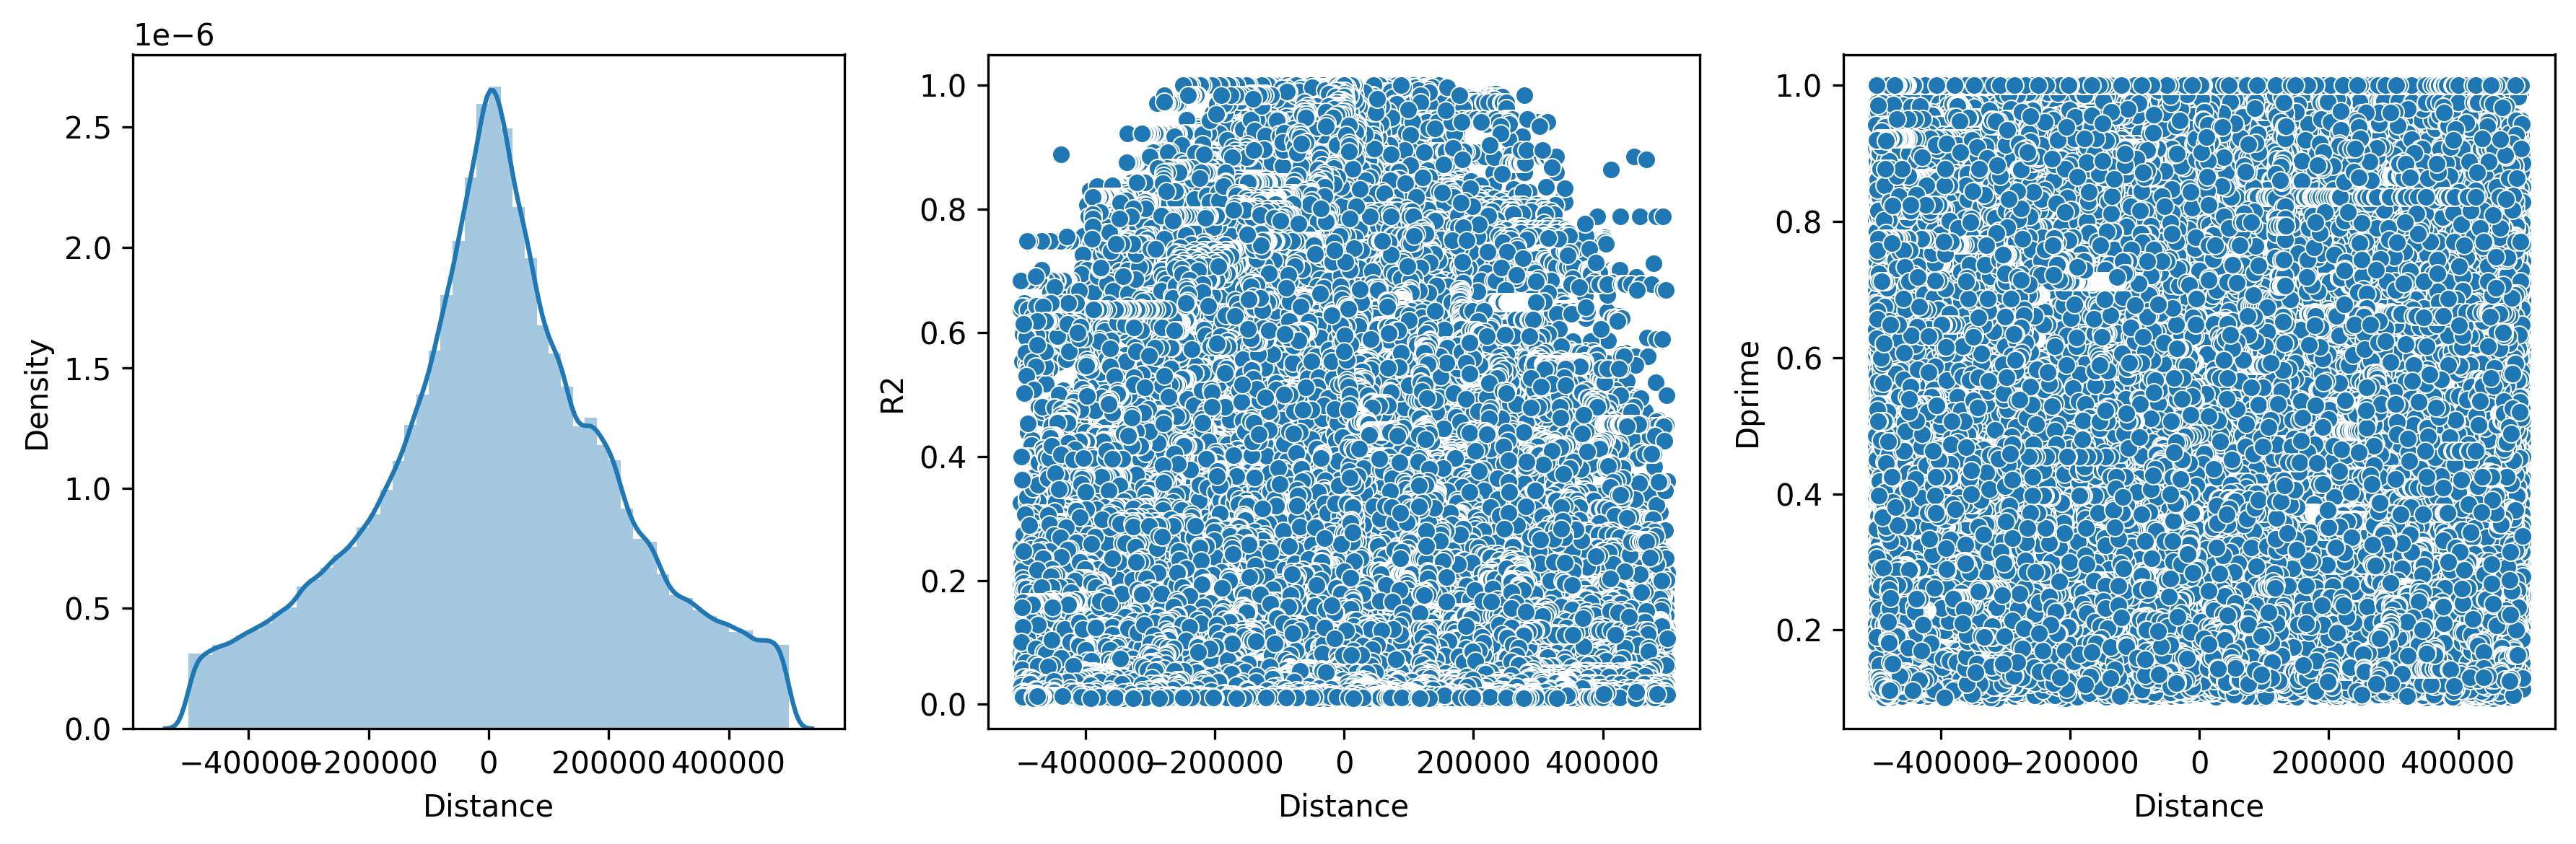

In [115]:
f, ax = plt.subplots(1,3, sharey=False, figsize=(12,4), dpi=300)
sns.distplot(all_LD.Distance, ax=ax[0])
sns.scatterplot(x=all_LD.Distance, y = all_LD.R2, ax = ax[1])
sns.scatterplot(x=all_LD.Distance, y = all_LD.Dprime, ax = ax[2])
f.tight_layout()

We can see that there is a hard cutoff at 500kb up or downstream of the query, and that there is some trend between distance and R2 value, as might be expected. Interestingly, there is not clear association with Dprime (but there is a great deal of overplotting).

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


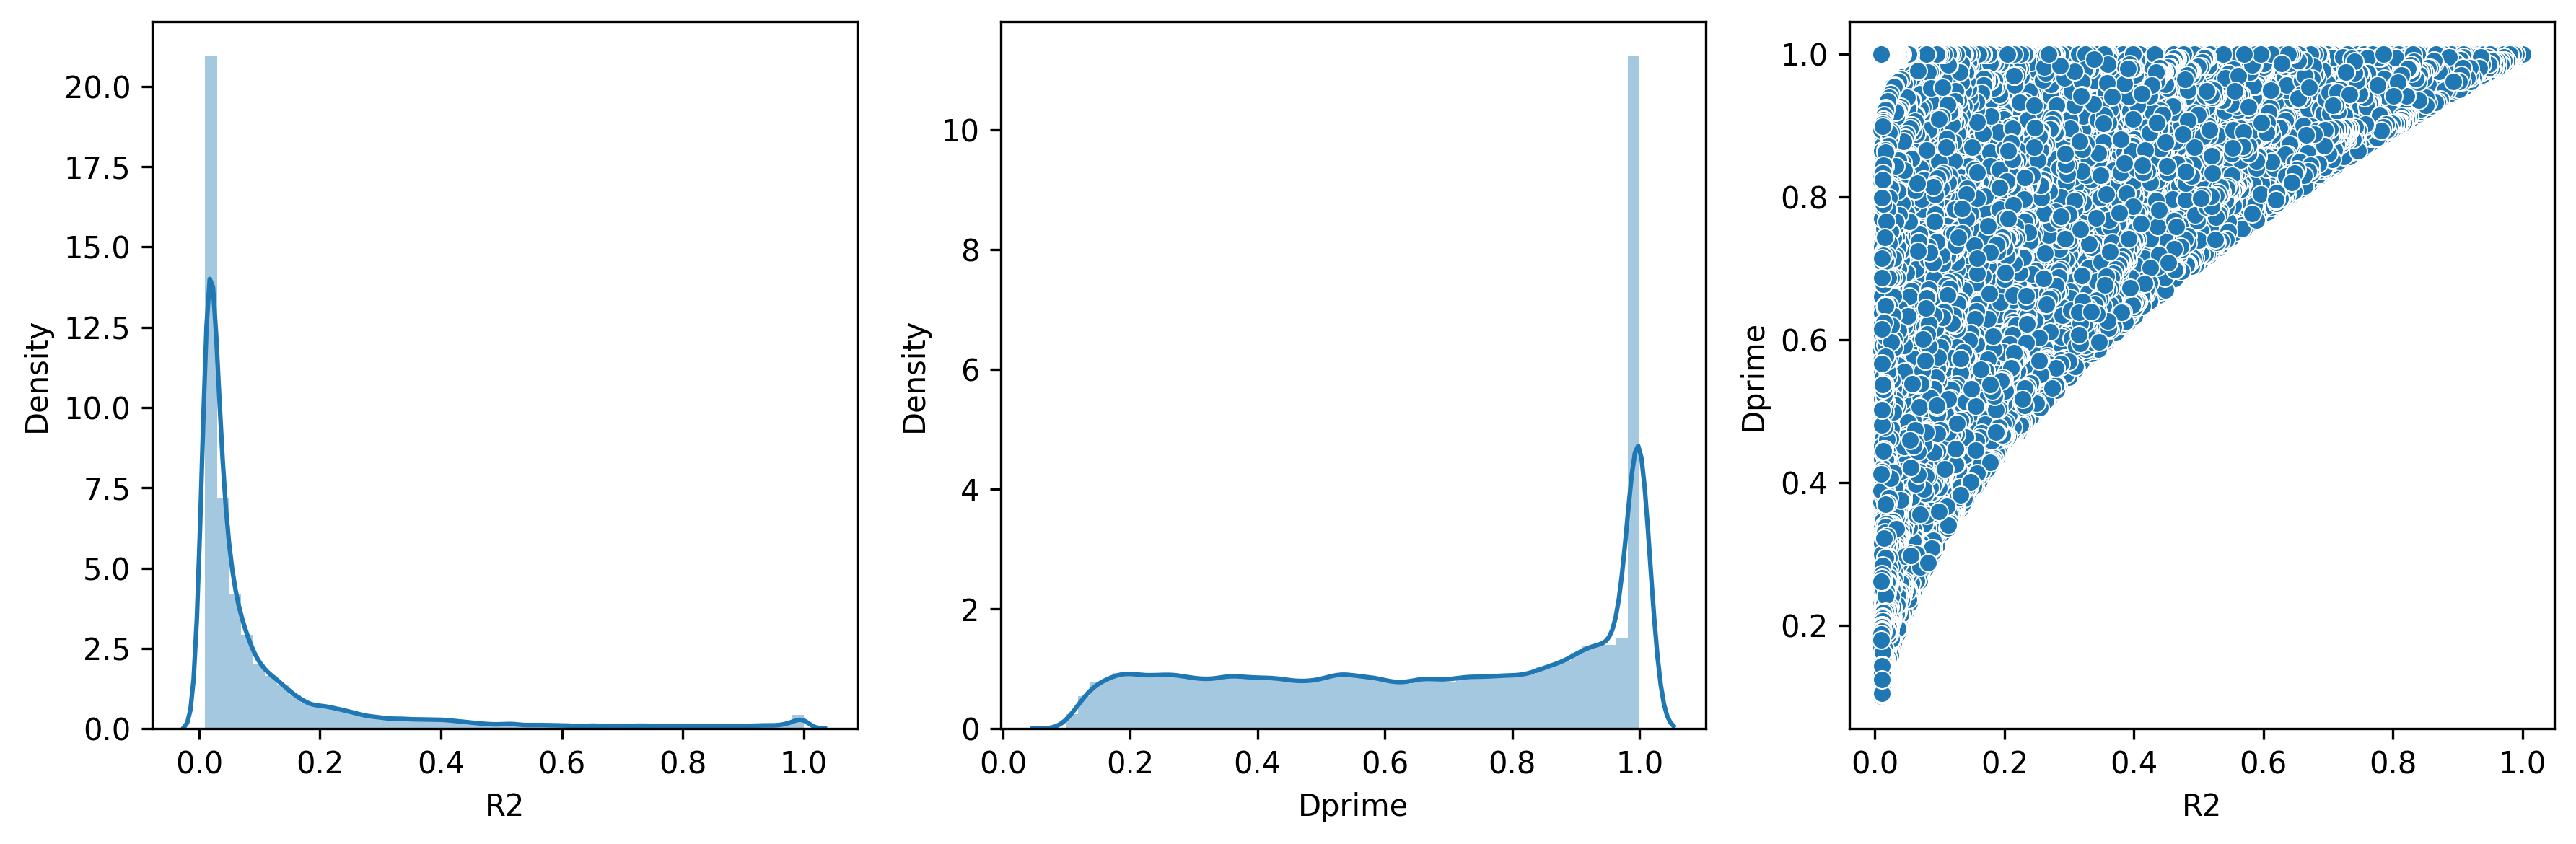

In [116]:
linkagePlots(all_LD)

In [117]:
len(all_LD.RS_Number.unique()) / len(all_LD)

0.35892064169289944

Josh: Only 43% of the returned LD SNPs are unique. However, the R2 values are going to depend on the query SNP, and all query SNP IDs used were unique. Therefore, we should filter based on R2 or Dprime *prior* to removing the redundant values.<br>

Revathy: Only 35% of the returned LD SNPs are unique.

In [148]:
all_LD_cutoff = all_LD[all_LD.R2 >= 0.8]
all_LD_cutoff

,RS_Number,Coord,Alleles,MAF,Distance,Dprime,R2,Correlated_Alleles,RegulomeDB,Function,Query
0,rs7809799,chr7:98760504,(G/A),0.0616,0,1.0000,1.0000,"G=G,A=A",4,NaN,rs7809799
1,rs2395051,chr7:98761201,(A/G),0.0606,697,1.0000,0.9828,"G=A,A=G",6,NaN,rs7809799
2,rs4729517,chr7:98761961,(G/A),0.0606,1457,1.0000,0.9828,"G=G,A=A",7,NaN,rs7809799
3,rs6962075,chr7:98757940,(A/G),0.0606,-2564,1.0000,0.9828,"G=A,A=G",7,NaN,rs7809799
4,rs6961749,chr7:98757715,(C/T),0.0606,-2789,1.0000,0.9828,"G=C,A=T",7,NaN,rs7809799
...,...,...,...,...,...,...,...,...,...,...,...
1096013,rs12340866,chr9:5094185,(G/A),0.2883,-165894,0.9027,0.8031,"C=G,T=A",7,NaN,rs1830610
1096014,rs10117459,chr9:5094034,(G/A),0.2883,-166045,0.9027,0.8031,"C=G,T=A",5,NaN,rs1830610
1096015,rs146385350,chr9:5090966,(TTG/-),0.2883,-169113,0.9027,0.8031,"C=TTG,T=-",.,NaN,rs1830610
1096016,rs2274649,chr9:5090934,(A/T),0.2883,-169145,0.9027,0.8031,"C=A,T=T",7,NaN,rs1830610


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


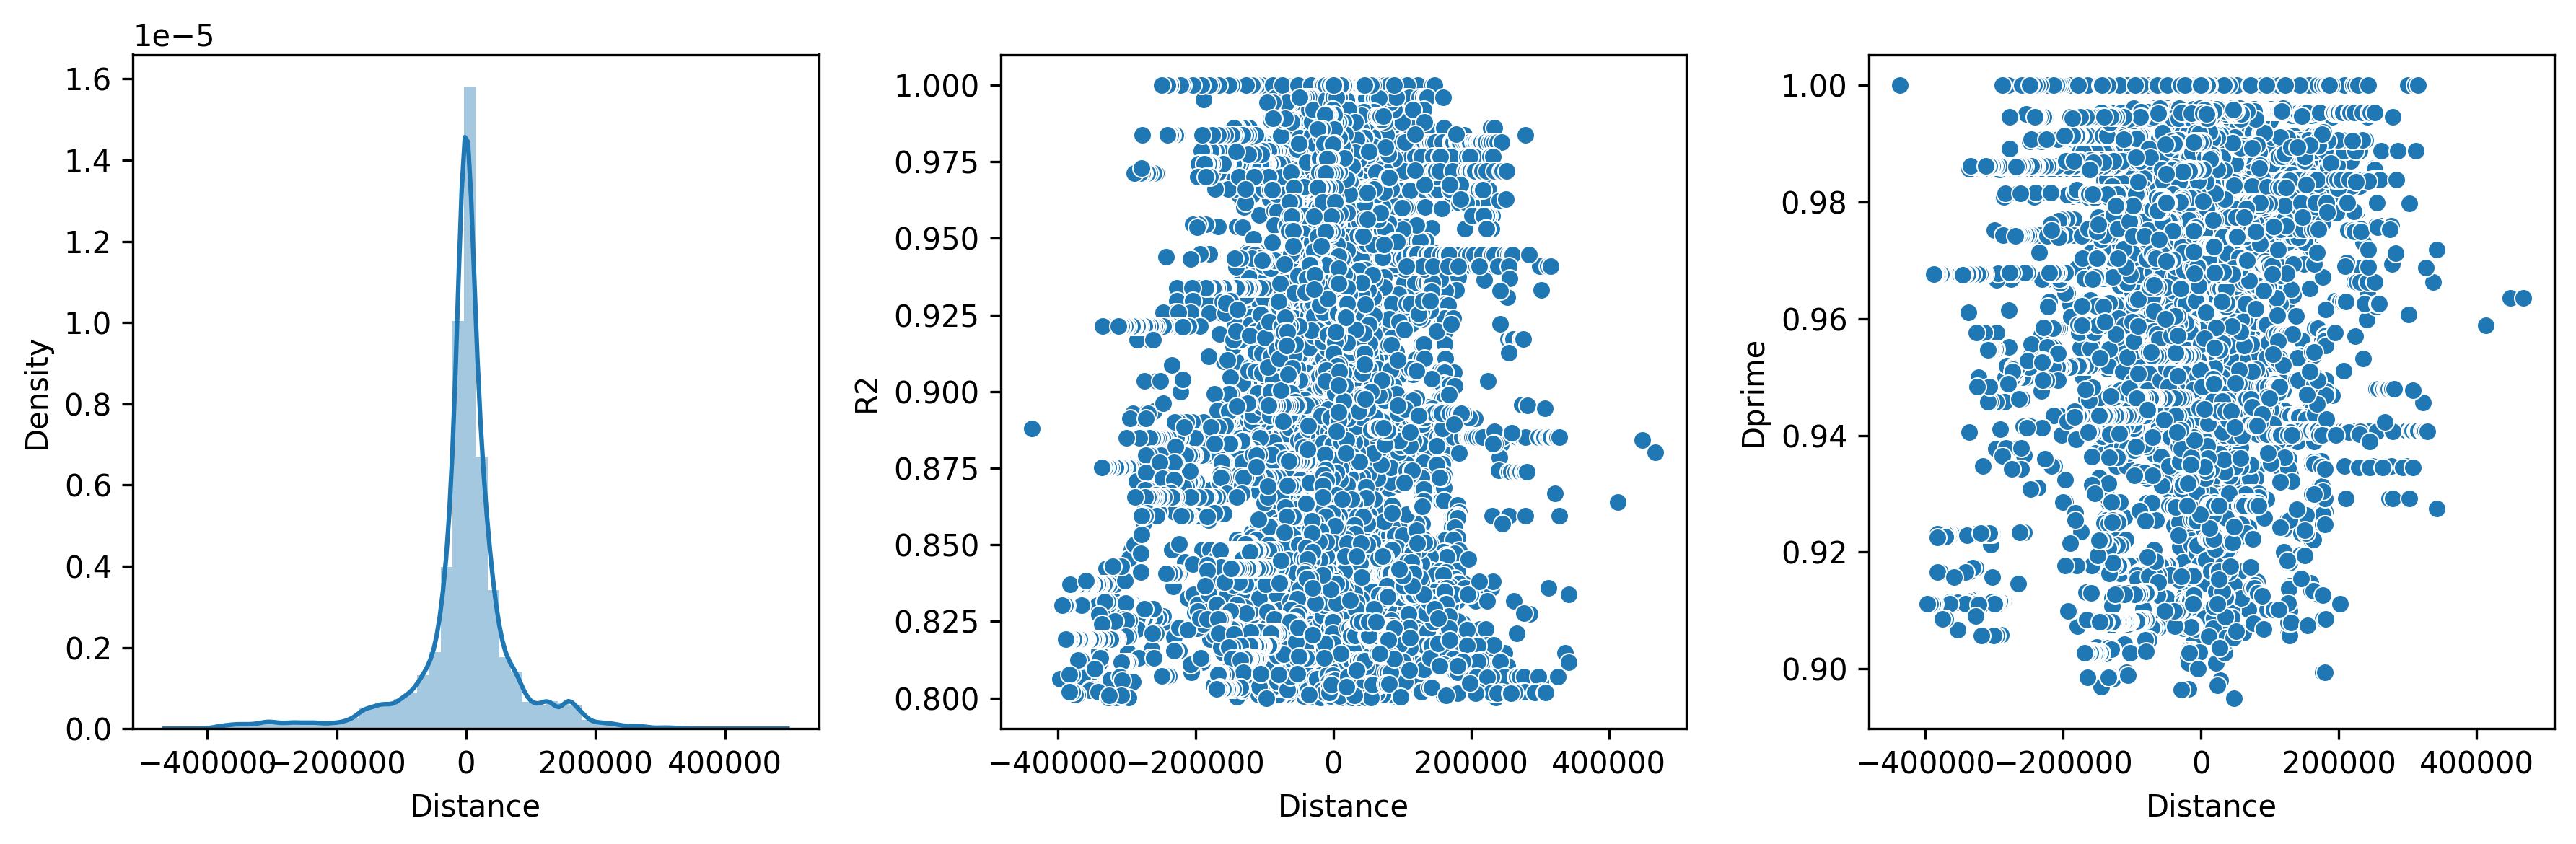

In [149]:
f, ax = plt.subplots(1,3, sharey=False, figsize=(12,4), dpi=300)
sns.distplot(all_LD_cutoff.Distance, ax=ax[0])
sns.scatterplot(x=all_LD_cutoff.Distance, y = all_LD_cutoff.R2, ax = ax[1])
sns.scatterplot(x=all_LD_cutoff.Distance, y = all_LD_cutoff.Dprime, ax = ax[2])
f.tight_layout()

Now we see that SNPs with R2 >= 0.8 have a much tighter distance distribution.

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


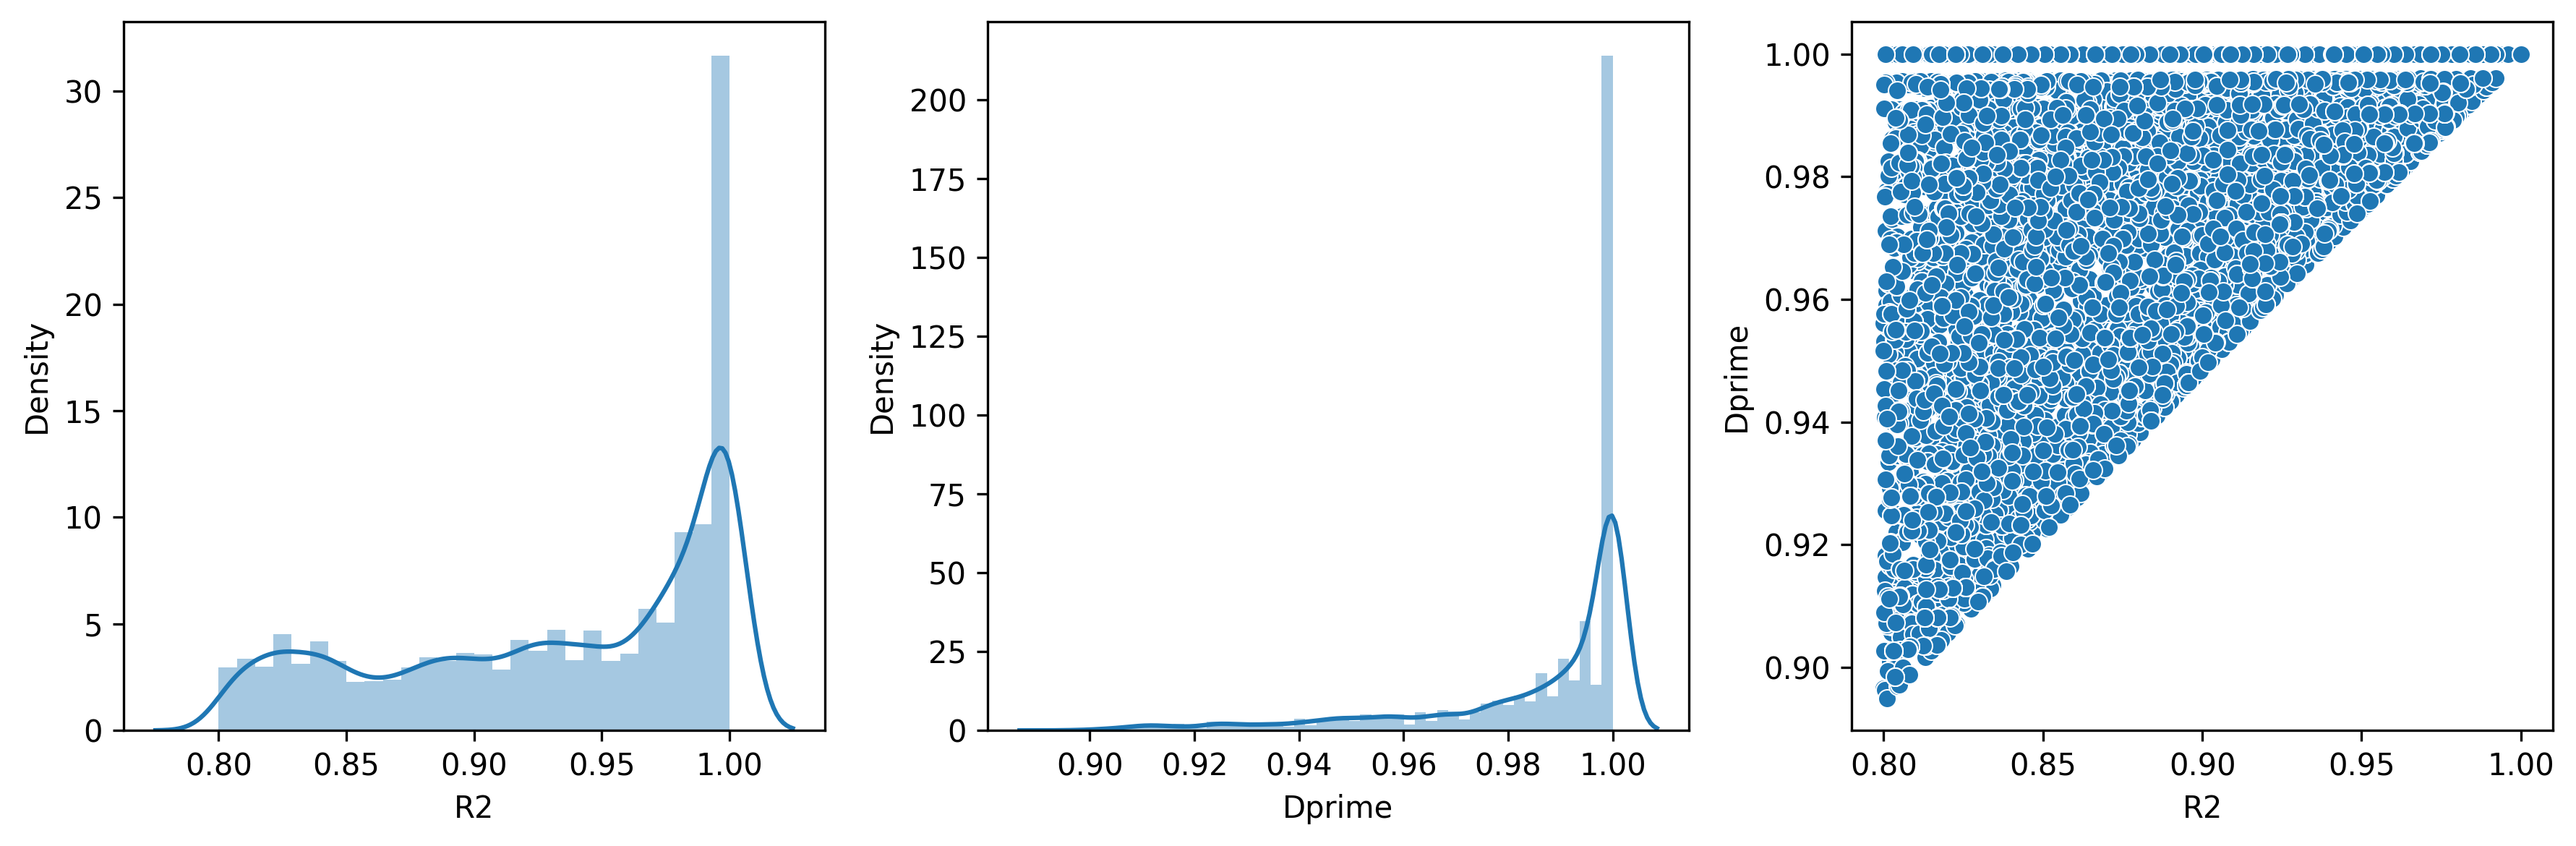

In [150]:
linkagePlots(all_LD_cutoff)

In [151]:
print("Percent Unique: %.4f" % (len(all_LD_cutoff.RS_Number.unique()) / len(all_LD_cutoff)))
print("Number of unique SNPs R2 >= 0.8: %d" % (len(all_LD_cutoff.Coord.unique())))

Percent Unique: 0.5483
Number of unique SNPs R2 >= 0.8: 15475


Now, ~70% of the SNPs are unique. However, there are some SNPs with no rs number that have "." as the value for RS_Number. These may be unique, and the coordinates should instead be compared. How many of them are there?

In [123]:
sum(['.' in x for x in all_LD_cutoff.RS_Number])

231

We can get the unique SNPs by first extracting the SNPs having an rs#, then using unique on those. Finally, for all SNPs *not* having an rs#, we will require that they have unique chromosomal coordinates. **Actually** we will just look for unique coordinates, which fixes the RS# problem.

In [48]:
# all_LD_cutoff_unique = all_LD_cutoff[['rs' in x for x in all_LD_cutoff.RS_Number]].drop_duplicates(subset='RS_Number')

In [49]:
# all_LD_cutoff_unique = pd.concat([all_LD_cutoff_unique, all_LD_cutoff[['.' in x for x in all_LD_cutoff.RS_Number]].drop_duplicates(subset='Coord')])

Couldn't I just filter them all based on chromosomal coordinate? Or do some have different alleles (that wouldn't really make sense as all alleles should be accounted for?)

In [124]:
all_LD_cutoff_unique = all_LD_cutoff.drop_duplicates(subset='Coord')

In [125]:
len(all_LD_cutoff_unique) # Both methods get essentially the same number (difference of 1)

15475

In [126]:
all_LD_cutoff_unique.head()

,RS_Number,Coord,Alleles,MAF,Distance,Dprime,R2,Correlated_Alleles,RegulomeDB,Function,Query
0,rs7809799,chr7:98760504,(G/A),0.0616,0,1.0,1.0000,"G=G,A=A",4,NaN,rs7809799
1,rs2395051,chr7:98761201,(A/G),0.0606,697,1.0,0.9828,"G=A,A=G",6,NaN,rs7809799
2,rs4729517,chr7:98761961,(G/A),0.0606,1457,1.0,0.9828,"G=G,A=A",7,NaN,rs7809799
3,rs6962075,chr7:98757940,(A/G),0.0606,-2564,1.0,0.9828,"G=A,A=G",7,NaN,rs7809799
4,rs6961749,chr7:98757715,(C/T),0.0606,-2789,1.0,0.9828,"G=C,A=T",7,NaN,rs7809799


## Convert coordinates to hg38 and output BED file
Now that we have all SNPs in LD with MS GWAS SNPs, we need to generate a file for visualization and for overlapping with ATAC peaks. We have extended our original list of SNPs from 531 to 9453, but the coordinate system is hg37. We need to convert them to hg38, which we will do with UCSC's liftOver tool. We will then output a BED file which we can use to visualize in IGV and to assess overlaps with ATAC peaks.

In [127]:
# Step 1: convert coordinates to BED (Do we need to adjust for 0-based, half-open?)
all_LD_cutoff_bed = all_LD_cutoff_unique.Coord.str.split(':', expand=True)
all_LD_cutoff_bed[1] = all_LD_cutoff_bed[1].astype(int)
all_LD_cutoff_bed[2] = all_LD_cutoff_bed[1] + 1
all_LD_cutoff_bed[3] = all_LD_cutoff_unique.RS_Number

In [130]:
all_LD_cutoff_bed.to_csv("all_LD_SNPs_IBD_R0.8unique_hg19.bed", sep="\t", quoting=None, header=False, index=False)

In [131]:
%%bash
/Users/rv103/Downloads/liftOver \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/all_LD_SNPs_IBD_R0.8unique_hg19.bed \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/source_snps/hg19ToHg38.over.chain \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/all_LD_SNPs_IBD_R0.8unique_hg38.bed \
lift_unmapped.bed

Reading liftover chains
Mapping coordinates


In [132]:
# Output the query SNPs also NEED TO FIX THE INPUT HG38 IDS*****
query_snps = all_LD[all_LD.Distance == 0]
query_snps_bed = query_snps.Coord.str.split(':', expand=True)
query_snps_bed[1] = query_snps_bed[1].astype(int)
query_snps_bed[2] = query_snps_bed[1] + 1
query_snps_bed[3] = query_snps.Query

In [133]:
query_snps_bed.to_csv("query_gwas_snps_ibd_hg19.bed", sep="\t", quoting=None, header=False, index=False)

In [134]:
%%bash
/Users/rv103/Downloads/liftOver \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/query_gwas_snps_ibd_hg19.bed \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/source_snps/hg19ToHg38.over.chain \
/Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/query_gwas_snps_ibd_hg38.bed \
lift_unmapped_query.bed

Reading liftover chains
Mapping coordinates


In [135]:
len(query_snps)

649

In [138]:
!head /Users/rv103/Revathy/Duke/Collab/20210113_Maria/human-th-ms/data/snp_data/all_LD_SNPs_IBD_R0.8unique_hg38.bed

chr7	99162881	99162882	rs7809799
chr7	99163578	99163579	rs2395051
chr7	99164338	99164339	rs4729517
chr7	99160317	99160318	rs6962075
chr7	99160092	99160093	rs6961749
chr7	99165796	99165797	rs1918019
chr7	99165892	99165893	rs2395050
chr7	99166398	99166399	rs6956645
chr7	99166625	99166626	rs6465739
chr7	99166777	99166778	rs7790575


In [140]:
len(all_LD.RS_Number.unique())

393704

In [141]:
all_LD.shape

(1096911, 11)